In [1]:
import argparse
import os
import pickle
import time
from itertools import product
from math import inf, pi

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import jax.debug as jdb

import numpy as np

from tqdm.auto import tqdm

from dynamics import prior, disturbance, plant
from utils import params_to_posdef
from utils import random_ragged_spline, spline
from utils import (tree_normsq, rk38_step, epoch,   # noqa: E402
                   odeint_fixed_step, odeint_ckpt, random_ragged_spline, spline,
            params_to_cholesky, params_to_posdef)

from functools import partial
import matplotlib.pyplot as plt
import csv

plt.rcParams.update({'font.size': 24})

In [2]:
def convert_p_qbar(p):
    return np.sqrt(1/(1 - 1/p) - 1.1)

def convert_qbar_p(qbar):
    return 1/(1 - 1/(1.1 + qbar**2))

In [3]:
# Support functions for generating loop reference trajectory
def reference(t):
    T = 10.            # loop period
    d = 4.             # displacement along `x` from `t=0` to `t=T`
    w = 4.             # loop width
    h = 6.             # loop height
    ϕ_max = jnp.pi/3   # maximum roll angle (achieved at top of loop)

    x = (w/2)*jnp.sin(2*jnp.pi * t/T) + d*(t/T)
    y = (h/2)*(1 - jnp.cos(2*jnp.pi * t/T))
    ϕ = 4*ϕ_max*(t/T)*(1-t/T)
    r = jnp.array([x, y, ϕ])
    return r

def odeint_fixed_step(func, x0, t0, t1, step_size, *args):
    """TODO: docstring."""
    # Use `numpy` for purely static operations on static arguments
    # (see: https://github.com/google/jax/issues/5208)
    # jdebug.print('{t1_type}', t1_type=type(t1))
    num_steps = 10

    ts = jnp.linspace(t0, t1, num_steps + 1)
    xs = odeint_ckpt(func, x0, ts, *args)
    return xs, ts

In [4]:
def test_simulate(ts, w, params, reference,
                plant=plant, prior=prior, disturbance=disturbance, NGD_flag=False):
    """TODO: docstring."""
    # Required derivatives of the reference trajectory
    def ref_derivatives(t):
        ref_vel = jax.jacfwd(reference)
        ref_acc = jax.jacfwd(ref_vel)
        r = reference(t)
        dr = ref_vel(t)
        ddr = ref_acc(t)
        return r, dr, ddr

    # Adaptation law
    def adaptation_law(q, dq, r, dr, params=params, NGD_flag=NGD_flag):
        # Regressor features
        y = jnp.concatenate((q, dq))
        for W, b in zip(params['W'], params['b']):
            y = jnp.tanh(W@y + b)

        # Auxiliary signals
        Λ, P = params['Λ'], params['P']
        e, de = q - r, dq - dr
        s = de + Λ@e

        if NGD_flag:
            dA = jnp.outer(s, y) @ P
        else:
            dA = P @ jnp.outer(s, y)
        return dA, y

    # Controller
    def controller(q, dq, r, dr, ddr, f_hat, params=params):
        # Auxiliary signals
        Λ, K = params['Λ'], params['K']
        e, de = q - r, dq - dr
        s = de + Λ@e
        v, dv = dr - Λ@e, ddr - Λ@de

        # Control input and adaptation law
        H, C, g, B = prior(q, dq)
        τ = H@dv + C@v + g - f_hat - K@s
        u = jnp.linalg.solve(B, τ)
        return u, τ

    # Closed-loop ODE for `x = (q, dq)`, with a zero-order hold on
    # the controller
    def ode(x, t, u, w=w):
        q, dq = x
        f_ext = disturbance(q, dq, w)
        ddq = plant(q, dq, u, f_ext)
        dx = (dq, ddq)
        return dx

    # Simulation loop
    def loop(carry, input_slice, params=params):
        t_prev, q_prev, dq_prev, u_prev, A_prev, dA_prev, pA_prev = carry
        t = input_slice
        zs, ts = odeint_fixed_step(ode, (q_prev, dq_prev), t_prev, t, 2e-3,
                            u_prev)
        qs, dqs = zs
        q = qs[-1]
        dq = dqs[-1]

        r, dr, ddr = ref_derivatives(t)

        if NGD_flag:
            qn = 1.1 + params['pnorm']**2

            # Integrate adaptation law via trapezoidal rule
            dA, y = adaptation_law(q, dq, r, dr)
            pA = pA_prev + (t - t_prev)*(dA_prev + dA)/2
            # A = (jnp.maximum(jnp.abs(pA), 1e-6 * jnp.ones_like(pA))**(qn-1) * jnp.sign(pA)* (jnp.ones_like(pA) - jnp.isclose(pA, 0, atol=1e-6)) ) @ params['P']
            A = jnp.abs(pA)**(qn-1) * jnp.sign(pA) @ params['P']
        else:
            # Integrate adaptation law via trapezoidal rule
            dA, y = adaptation_law(q, dq, r, dr)
            A = A_prev + (t - t_prev)*(dA_prev + dA)/2
            pA = pA0

        # Compute force estimate and control input
        f_hat = A @ y
        u, τ = controller(q, dq, r, dr, ddr, f_hat)

        f_ext = disturbance(q, dq, w)

        carry = (t, q, dq, u, A, dA, pA)
        flat_A = A.flatten()
        output_slice = (q, dq, u, τ, r, dr, f_hat, f_ext, y, flat_A)
        return carry, output_slice

    # Initial conditions
    t0 = ts[0]
    r0, dr0, ddr0 = ref_derivatives(t0)
    q0, dq0 = r0, dr0
    dA0, y0 = adaptation_law(q0, dq0, r0, dr0)
    A0 = jnp.zeros((q0.size, y0.size))
    pA0 = jnp.ones((q0.size, y0.size))
    f0 = A0 @ y0
    u0, τ0 = controller(q0, dq0, r0, dr0, ddr0, f0)
    f_ext0 = disturbance(q0, dq0, w)

    flat_A0 = A0.flatten()

    # Run simulation loop
    carry = (t0, q0, dq0, u0, A0, dA0, pA0)
    carry, output = jax.lax.scan(loop, carry, ts[1:])
    q, dq, u, τ, r, dr, f_hat, f_ext, y, flat_A = output

    # Prepend initial conditions
    q = jnp.vstack((q0, q))
    dq = jnp.vstack((dq0, dq))
    u = jnp.vstack((u0, u))
    τ = jnp.vstack((τ0, τ))
    r = jnp.vstack((r0, r))
    dr = jnp.vstack((dr0, dr))
    f_hat = jnp.vstack((f0, f_hat))
    f_ext = jnp.vstack((f_ext0, f_ext))
    flat_A = jnp.vstack((flat_A0, flat_A))
    y = jnp.vstack((y0, y))

    sim = {"q": q, "dq": dq, "u": u, "τ": τ, "r": r, "dr": dr, "f_hat": f_hat, "f_ext": f_ext, "y": y, "A": flat_A}

    return sim

In [5]:
def eval_single_model(model_dir, filename, T, dt, w, pnorm_flag=True, visual_verbose=0, save_dir=None, fixed_P=None):
    model_pkl_loc = os.path.join(model_dir, filename)
    with open(model_pkl_loc, 'rb') as f:
        train_results = pickle.load(f)

    test_results = {}
    test_params = {}  

    parts = filename.replace('.pkl', '').split('_')
        
    # Dictionary to hold the attributes for this file
    test_results['train_params'] = {}
    # Loop through each part of the filename
    for part in parts:
        # Split each part by '=' to separate the key and value
        key, value = part.split('=')
        # Convert value to float if it looks like a number, else keep as string
        try:
            test_results['train_params'][key] = float(value)
        except ValueError:
            test_results['train_params'][key] = value

    # Post-process training loss information
    # train_aux = train_results['train_lossaux_history']
    # train_loss_history = jnp.zeros(train_results['train_params']['E'])
    # for i in range(test_results['train_params']['E']):
    #     train_loss_history[i] = train_aux[i]['tracking_loss'] + 1e-3 * train_aux[i]['control_loss'] + 1e-4 * train_aux[i]['l2_penalty'] + test_results['train_params']['regP'] * train_aux[i]['reg_P_penalty']

    test_results['train_info'] = {
        'best_step_meta': train_results['best_step_meta'],
        'ensemble': train_results['ensemble'],
        'valid_loss_history': train_results['valid_loss_history'],
        # 'train_loss_history': train_results['train_loss_history'],
        'pnorm_history': train_results['pnorm_history']
    }
    # test_results['train_info']['pnorm_history'].prepend(test_results['train_params']['pinit'])

    if pnorm_flag:
        test_results['final_p'] = train_results['pnorm']
        # Note that the pnorm stored in pickle is the actual p
        # To run evaluation script, we convert params['pnorm'] to qbar
        test_params['pnorm'] = convert_p_qbar(train_results['pnorm'])
    else:
        test_results['final_p'] = 2.0
    

    # Store the model parameters
    test_params['W'] = train_results['model']['W']
    test_params['b'] = train_results['model']['b']
    test_params['Λ'] = params_to_posdef(train_results['controller']['Λ'])
    test_params['K'] = params_to_posdef(train_results['controller']['K'])
    if fixed_P == None:
        test_params['P'] = params_to_posdef(train_results['controller']['P'])
    else:
        P_size = params_to_posdef(train_results['controller']['P']).shape[0]
        test_params['P'] = jnp.eye(P_size) * fixed_P

    # Test on new trajectories
    ts = jnp.arange(0, T, dt)
    sim = test_simulate(ts, w, test_params, reference, NGD_flag=pnorm_flag)

    sim_e = sim['q'] - sim['r']
    tracking_error = jnp.mean(jnp.linalg.norm(sim_e, axis=1))
    sim_ftilde = sim['f_hat'] - sim['f_ext']
    estimation_error = jnp.mean(jnp.linalg.norm(sim_ftilde, axis=1))

    test_results['tracking_err'] = tracking_error
    test_results['estimation_err'] = estimation_error

    if os.path.exists(os.path.join(model_dir, 'figs')) == False:
        os.makedirs(os.path.join(model_dir, 'figs'))
        
    if visual_verbose > 0:
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        if test_results['train_params']['pfreq'] > test_results['train_params']['E']:
            ax[0].axhline(test_results['final_p'], 0, test_results['train_params']['E'], label='final p')
        else:
            ax[0].step(np.arange(0, test_results['train_params']['E'], test_results['train_params']['pfreq']), test_results['train_info']['pnorm_history'])
        ax[0].set_ylabel('p')
        ax[0].set_xlabel('Epochs')
        ax[0].set_title('p_init = {}'.format(test_results['train_params']['pinit']))

        ax[1].plot(range(int(test_results['train_params']['E'])), test_results['train_info']['valid_loss_history'])
        ax[1].set_title('Validation Loss')
        ax[1].set_ylabel('Val Loss')
        ax[1].set_xlabel('Epochs')

        fig.tight_layout()
        fig.savefig(os.path.join(model_dir, 'figs/train_info_{}'.format(filename.replace('.pkl', '.png'))))
        plt.close(fig)

        if visual_verbose > 1:
            fig, ax = plt.subplots(1, 3, figsize=(30, 10))
            ax[0].plot(ts, sim['q'][:, 0], label='q')
            ax[0].plot(ts, sim['r'][:, 0], label='r')
            ax[0].set_ylabel('x')
            ax[0].set_xlabel('t')
            ax[0].legend()

            ax[1].plot(ts, sim['q'][:, 1], label='q')
            ax[1].plot(ts, sim['r'][:, 1], label='r')
            ax[1].set_ylabel('y')
            ax[1].set_xlabel('t')
            ax[1].legend()

            ax[2].plot(ts, sim['q'][:, 2], label='q')
            ax[2].plot(ts, sim['r'][:, 2], label='r')
            ax[2].set_ylabel('ϕ')
            ax[2].set_xlabel('t')
            ax[2].legend()

            fig.tight_layout()
            fig.savefig(os.path.join(model_dir, 'figs/tracking_{}'.format(filename.replace('.pkl', '.png'))))
            plt.close(fig)
            if visual_verbose > 2:
                fig, ax = plt.subplots(1, 3, figsize=(30, 10))
                ax[0].plot(ts, sim['f_hat'][:, 0], label='f_hat')
                ax[0].plot(ts, sim['f_ext'][:, 0], label='f_ext')
                ax[0].set_ylabel('f_x')
                ax[0].set_xlabel('t')
                ax[0].legend()

                ax[1].plot(ts, sim['f_hat'][:, 1], label='f_hat')
                ax[1].plot(ts, sim['f_ext'][:, 1], label='f_ext')
                ax[1].set_ylabel('f_y')
                ax[1].set_xlabel('t')
                ax[1].legend()

                ax[2].plot(ts, sim['f_hat'][:, 2], label='f_hat')
                ax[2].plot(ts, sim['f_ext'][:, 2], label='f_ext')
                ax[2].set_ylabel('τ')
                ax[2].set_xlabel('t')
                ax[2].legend()

                fig.tight_layout()
                fig.savefig(os.path.join(model_dir, 'figs/estimation_{}'.format(filename.replace('.pkl', '.png'))))
                plt.close(fig)

    sim['ts'] = ts
    test = {
            'sim': sim,
            'params': test_params,
            'results': test_results,
            }
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        with open(os.path.join(save_dir, 'test_' + filename), 'wb') as f:
            pickle.dump(test, f)

    return sim, test_params, test_results

In [6]:
import urllib.parse

def eval_dir_models_fig(model_dir, T, dt, w, pnorm_flag=True, visual_verbose=0, save_dir=None, fixed_P=None):
    if fixed_P == None:
        csv_file_path = os.path.join(model_dir, 'model_test_results.csv')
    else:
        csv_file_path = os.path.join(model_dir, 'model_test_results_fixed_P_{}.csv'.format(fixed_P))
    Header = ['Seed', 'M', 'Epoch', 'init_p', 'p_freq', 'reg_P', 'best_step', 'final_p', 'Test Tracking Error', 'Test Estimation Error', 'Frob(P)', 'Loss plot', 'Trajectory plot', 'Estimation plot']
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(Header)

        for filename in tqdm(os.listdir(model_dir)):
            if filename.endswith(".pkl"):
                model_sim, model_test_params, model_test_results = eval_single_model(model_dir, filename, T, dt, w, pnorm_flag, visual_verbose, save_dir=save_dir, fixed_P=fixed_P)
                global_path = '/Users/sunbochentang/Documents/Local_Project/Research/COML/COML_Ablation'
                fig1_path = os.path.join(global_path, model_dir, 'figs/train_info_{}'.format(filename.replace('.pkl', '.png')))
                fig2_path = os.path.join(global_path, model_dir, 'figs/tracking_{}'.format(filename.replace('.pkl', '.png')))
                fig3_path = os.path.join(global_path, model_dir, 'figs/estimation_{}'.format(filename.replace('.pkl', '.png')))
                # Write the results to the csv file
                row = [model_test_results['train_params']['seed'], model_test_results['train_params']['M'], model_test_results['train_params']['E'], model_test_results['train_params']['pinit'], model_test_results['train_params']['pfreq'], model_test_results['train_params']['regP'], model_test_results['train_info']['best_step_meta'], model_test_results['final_p'], model_test_results['tracking_err'], model_test_results['estimation_err'], np.linalg.norm(model_test_params['P'])]
                if visual_verbose > 0:
                    fig1_url = 'file://' + urllib.parse.quote(fig1_path)
                    row.append(fig1_url)
                    if visual_verbose > 1:
                        fig2_url = 'file://' + urllib.parse.quote(fig2_path)
                        row.append(fig2_url)
                        if visual_verbose > 2:
                            fig3_url = 'file://' + urllib.parse.quote(fig3_path)
                            row.append(fig3_url)
                writer.writerow(row)

In [7]:
# ts_sim, test_params, aux = eval_single_model('train_results/pnorm_varfreq', 'seed=0_M=25_E=5000_pinit=1.50_pfreq=50_regP=10.00.pkl', 5.0, 0.02, 6.5, True, visual_verbose=2)

In [8]:
# eval_dir_models_fig('train_results/pnorm_fixed', 5.0, 0.01, 6.5, True, visual_verbose=3, save_dir='test_results/pnorm_fixed')
eval_dir_models_fig('train_results/pnorm_varfreq_regP4', 5.0, 0.01, 6.5, True, visual_verbose=3, save_dir='test_results/pnorm_varfreq_regP4', fixed_P=None)

  0%|          | 0/9 [00:00<?, ?it/s]

## Compare Model Performances

A function that compares models with same parameter

In [118]:
import re


def find_files_with_parameters(directory, params):
    """Find files in the given directory that match all specified parameter-value pairs, accounting for underscores."""
    # Build a regex pattern considering underscores and file naming conventions
    pattern_parts = []
    for param, value in params.items():
        part = rf"(?:_{param}={value}_|_{param}={value}\.pkl$)"
        pattern_parts.append(part)
    pattern = re.compile(r''.join(pattern_parts))
    
    matching_files = []
    for f in os.listdir(directory):
        if all(re.search(part, f) for part in pattern_parts):
            matching_files.append(f)
            
    return matching_files

def compare_models(params, test_dir, compare_param):
    matched_pkl = find_files_with_parameters(test_dir, params)
    all_tests = []

    for test_file in matched_pkl:
        with open(os.path.join(test_dir, test_file), 'rb') as f:
            test_dict = pickle.load(f)
        all_tests.append(test_dict)
    
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    fig2, ax2 = plt.subplots(1, 3, figsize=(30, 10))
    for test_id, test in enumerate(all_tests):
        for i in range(3):
            # Plot tracking history
            if test_id == 0:
                ax[i].plot(test['sim']['ts'], test['sim']['r'][:, i], 'r--', linewidth=4, label="Reference")
            ax[i].plot(test['sim']['ts'], test['sim']['q'][:, i], linewidth=2, label=f"pfinal={test['results']['final_p']: .3f}")
            ax[i].set_ylabel(f'x_{i}')
            ax[i].set_xlabel('t')
            if i == 2:
                ax[i].set_ylim([-pi/2, pi/2])
            else:
                ax[i].set_ylim([-2.0, 8.0])
            ax[i].legend()

            # Plot estimation history
            ax2[i].plot(test['sim']['ts'], test['sim']['f_hat'][:, i] - test['sim']['f_ext'][:, i], linewidth=2, label=f"pfinal={test['results']['final_p']: .3f}")
            ax2[i].set_ylabel(f'f_{i}')
            ax2[i].set_xlabel('t')
            ax2[i].set_ylim([-10.0, 10.0])
            ax2[i].legend()
    fig.tight_layout()
    fig2.tight_layout()
    plt.show()

### Case 1: `M=50`, `p_freq=50`

Currently `Frobenius_norm(P)` is not correctly normalized: the loss function component is essentially `Frobenius_norm(P)/(M * num_traj)`. Thus with `M=50` we see a lot of oscillations and instability, especially when `reg_P=5`

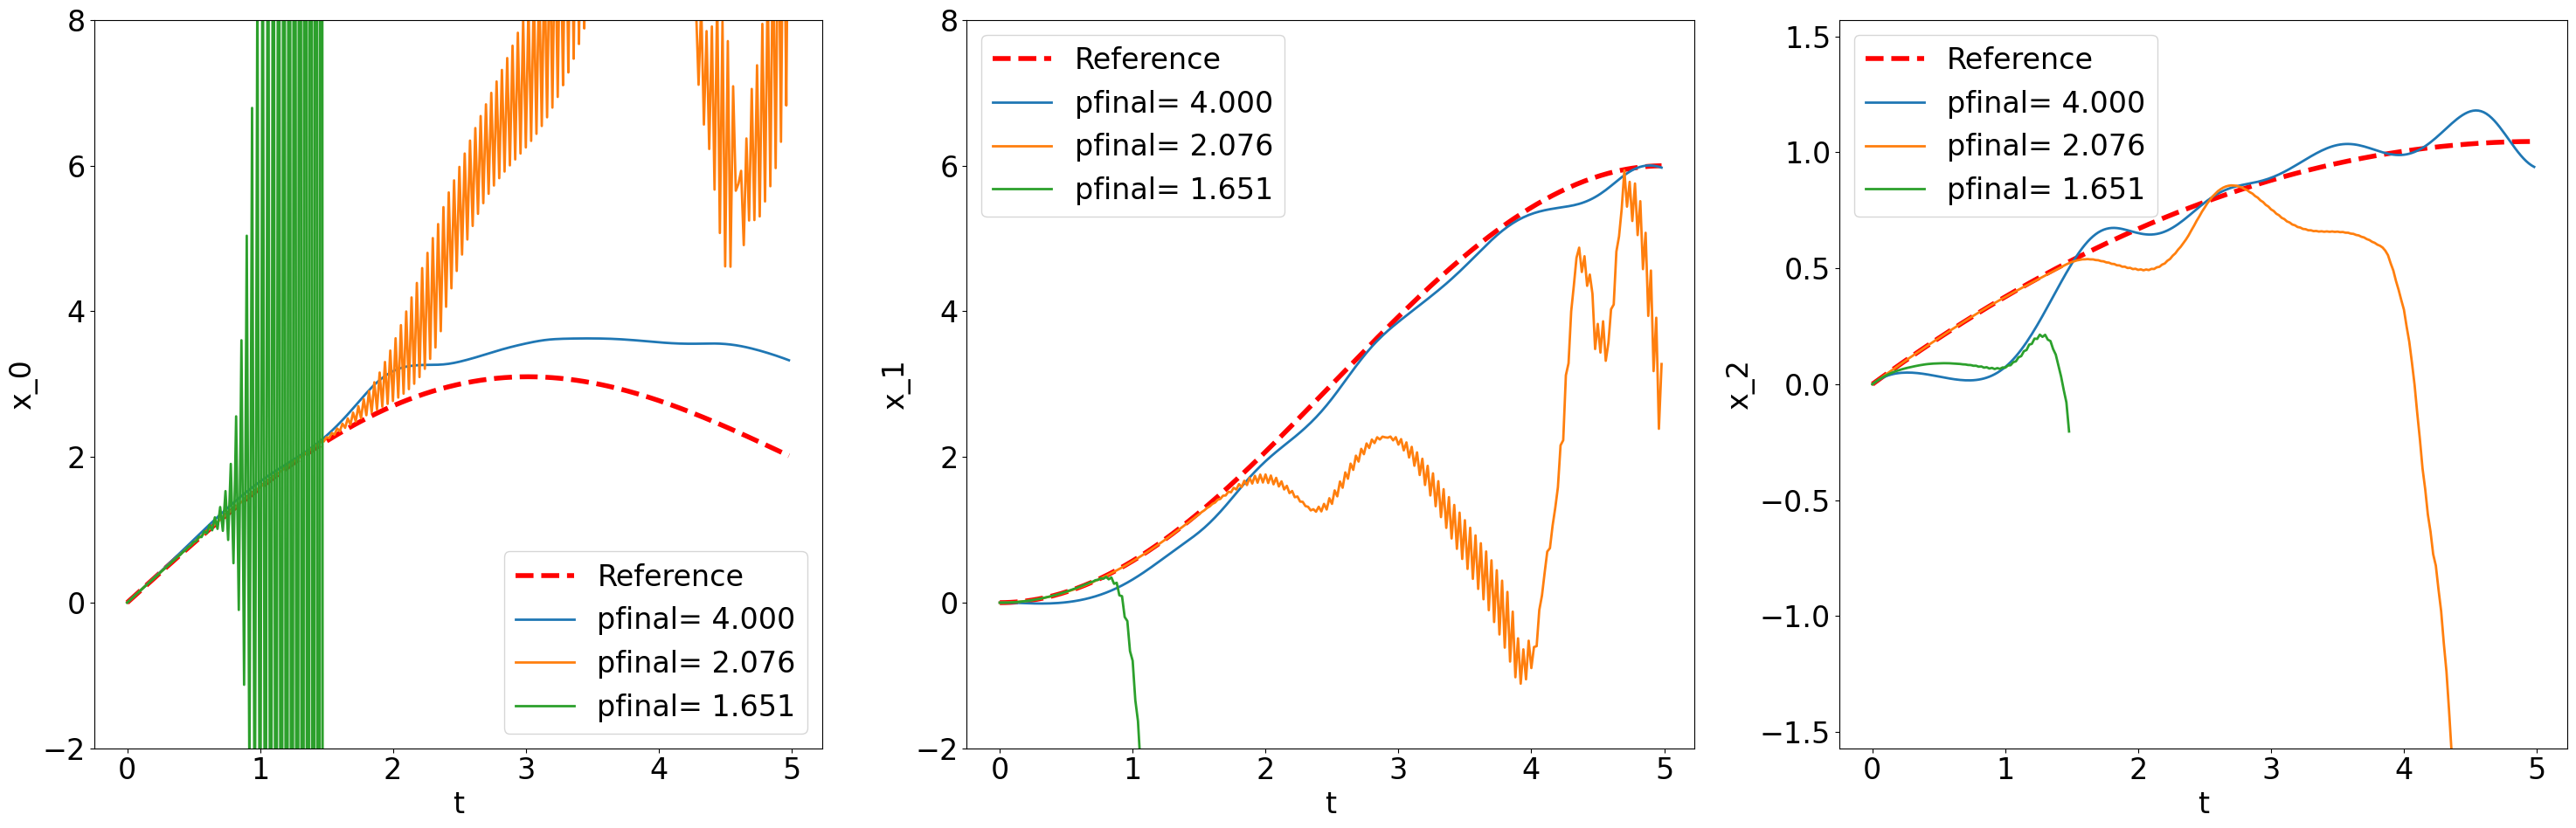

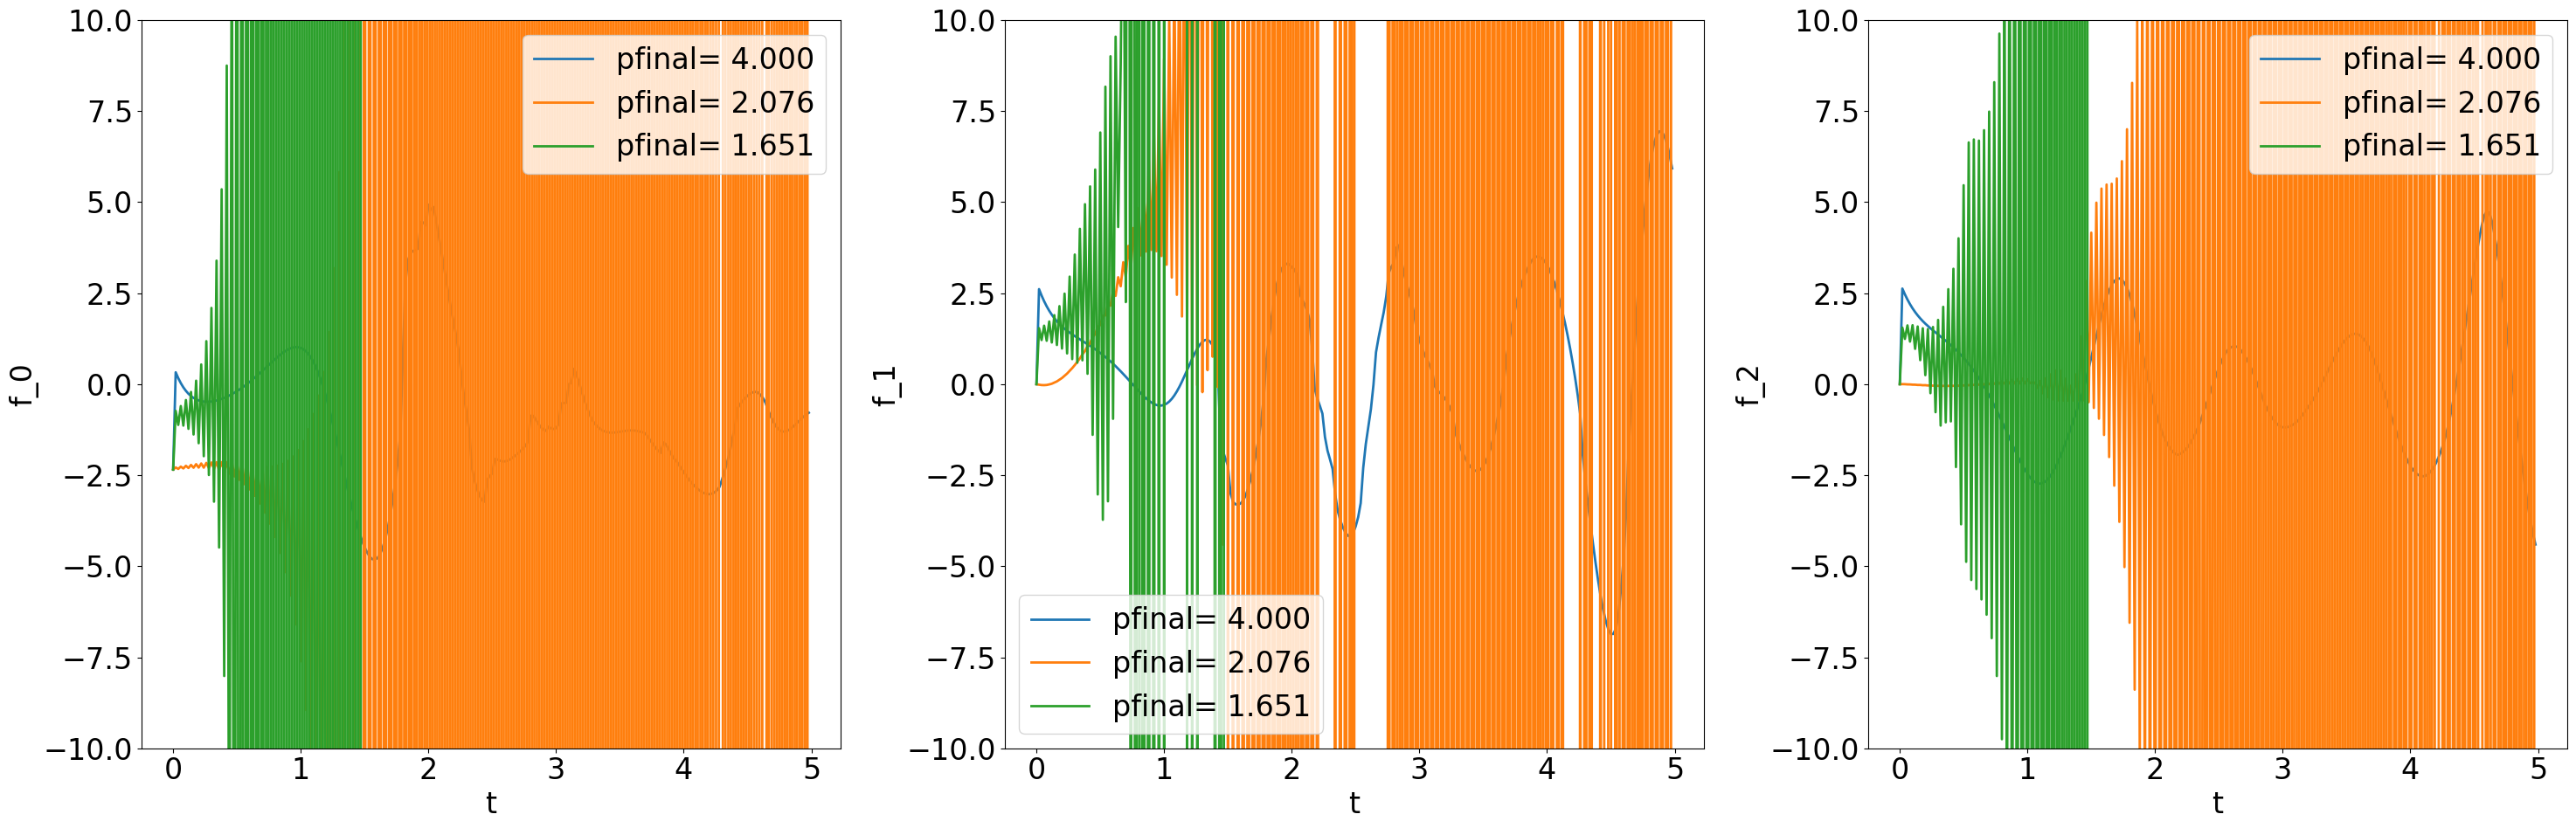

In [125]:
params = {
    'seed': '0',
    'M': '50',
    'pfreq': '50',
    'regP': '5.00',
}
compare_models(params, 'test_results/pnorm_varfreq', 'pinit')

`reg_P=10`

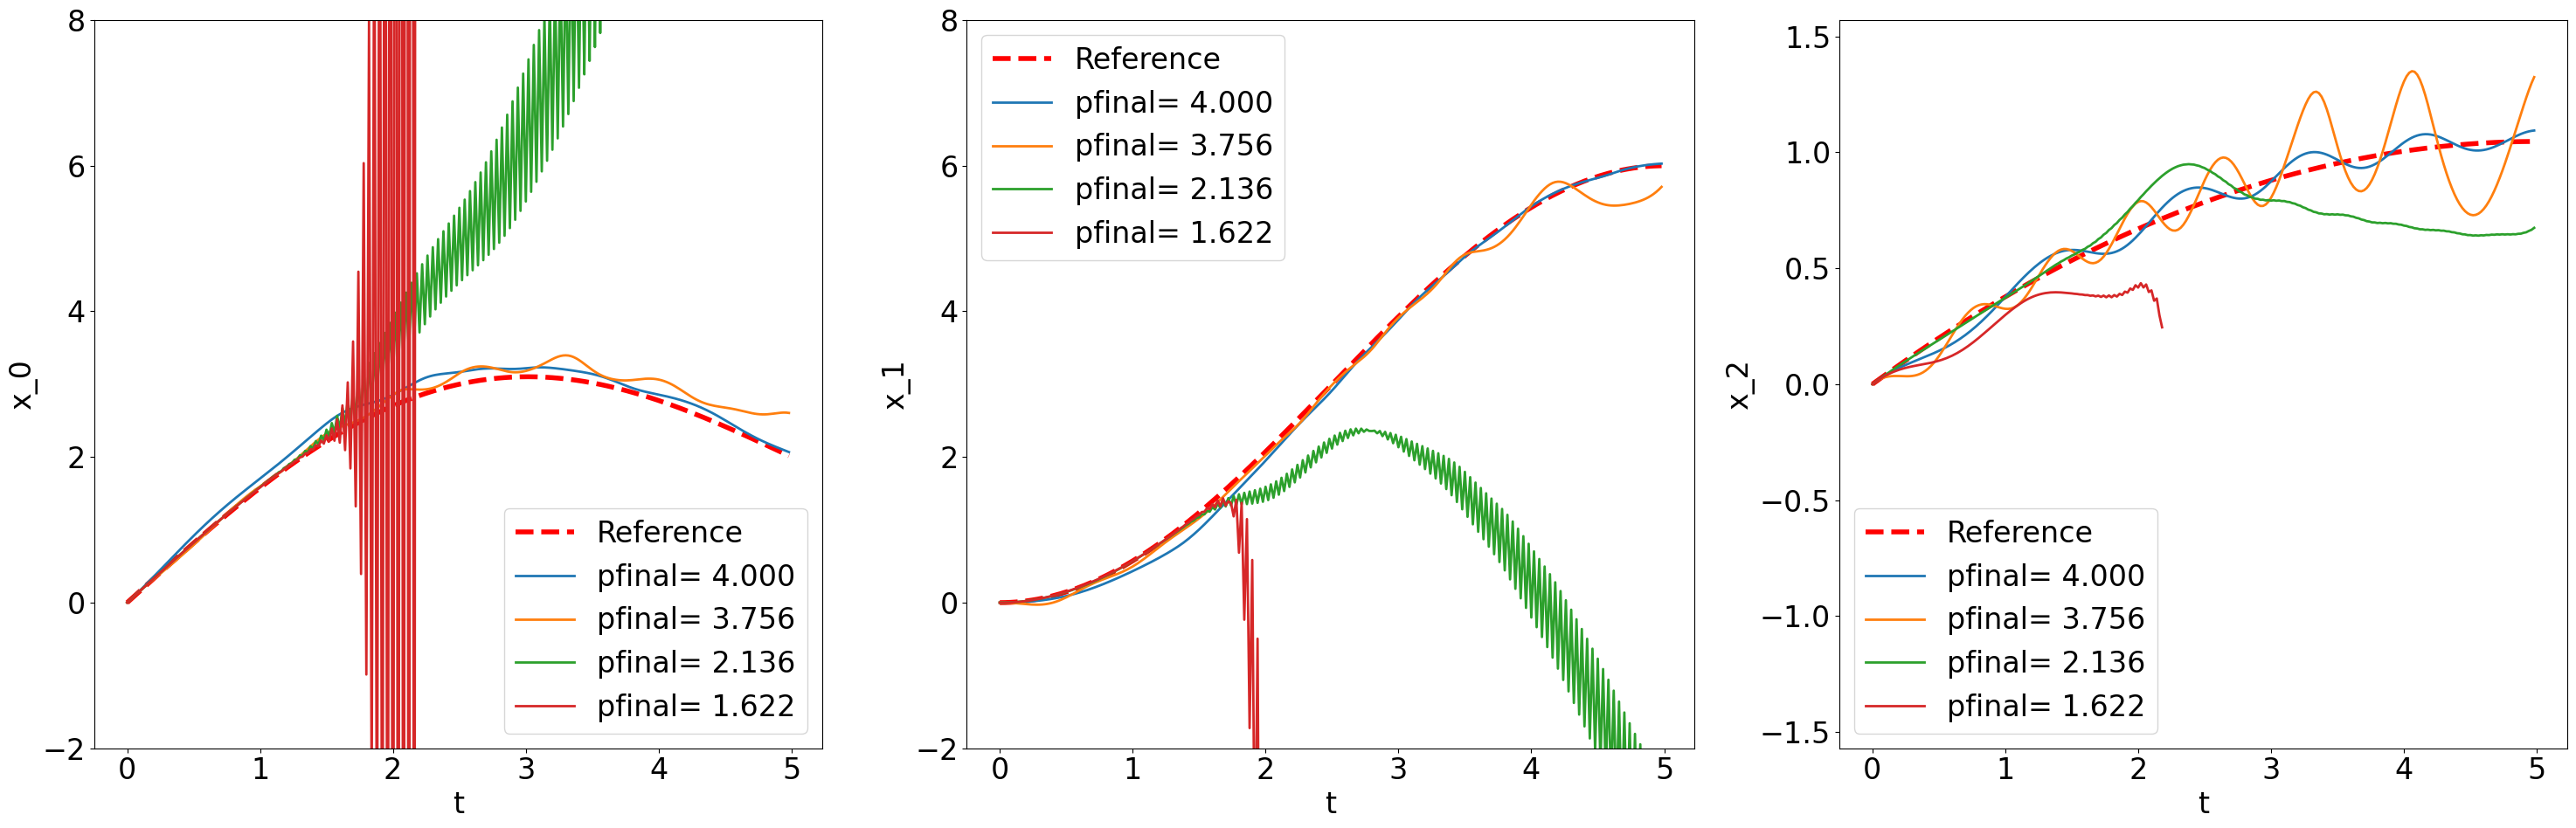

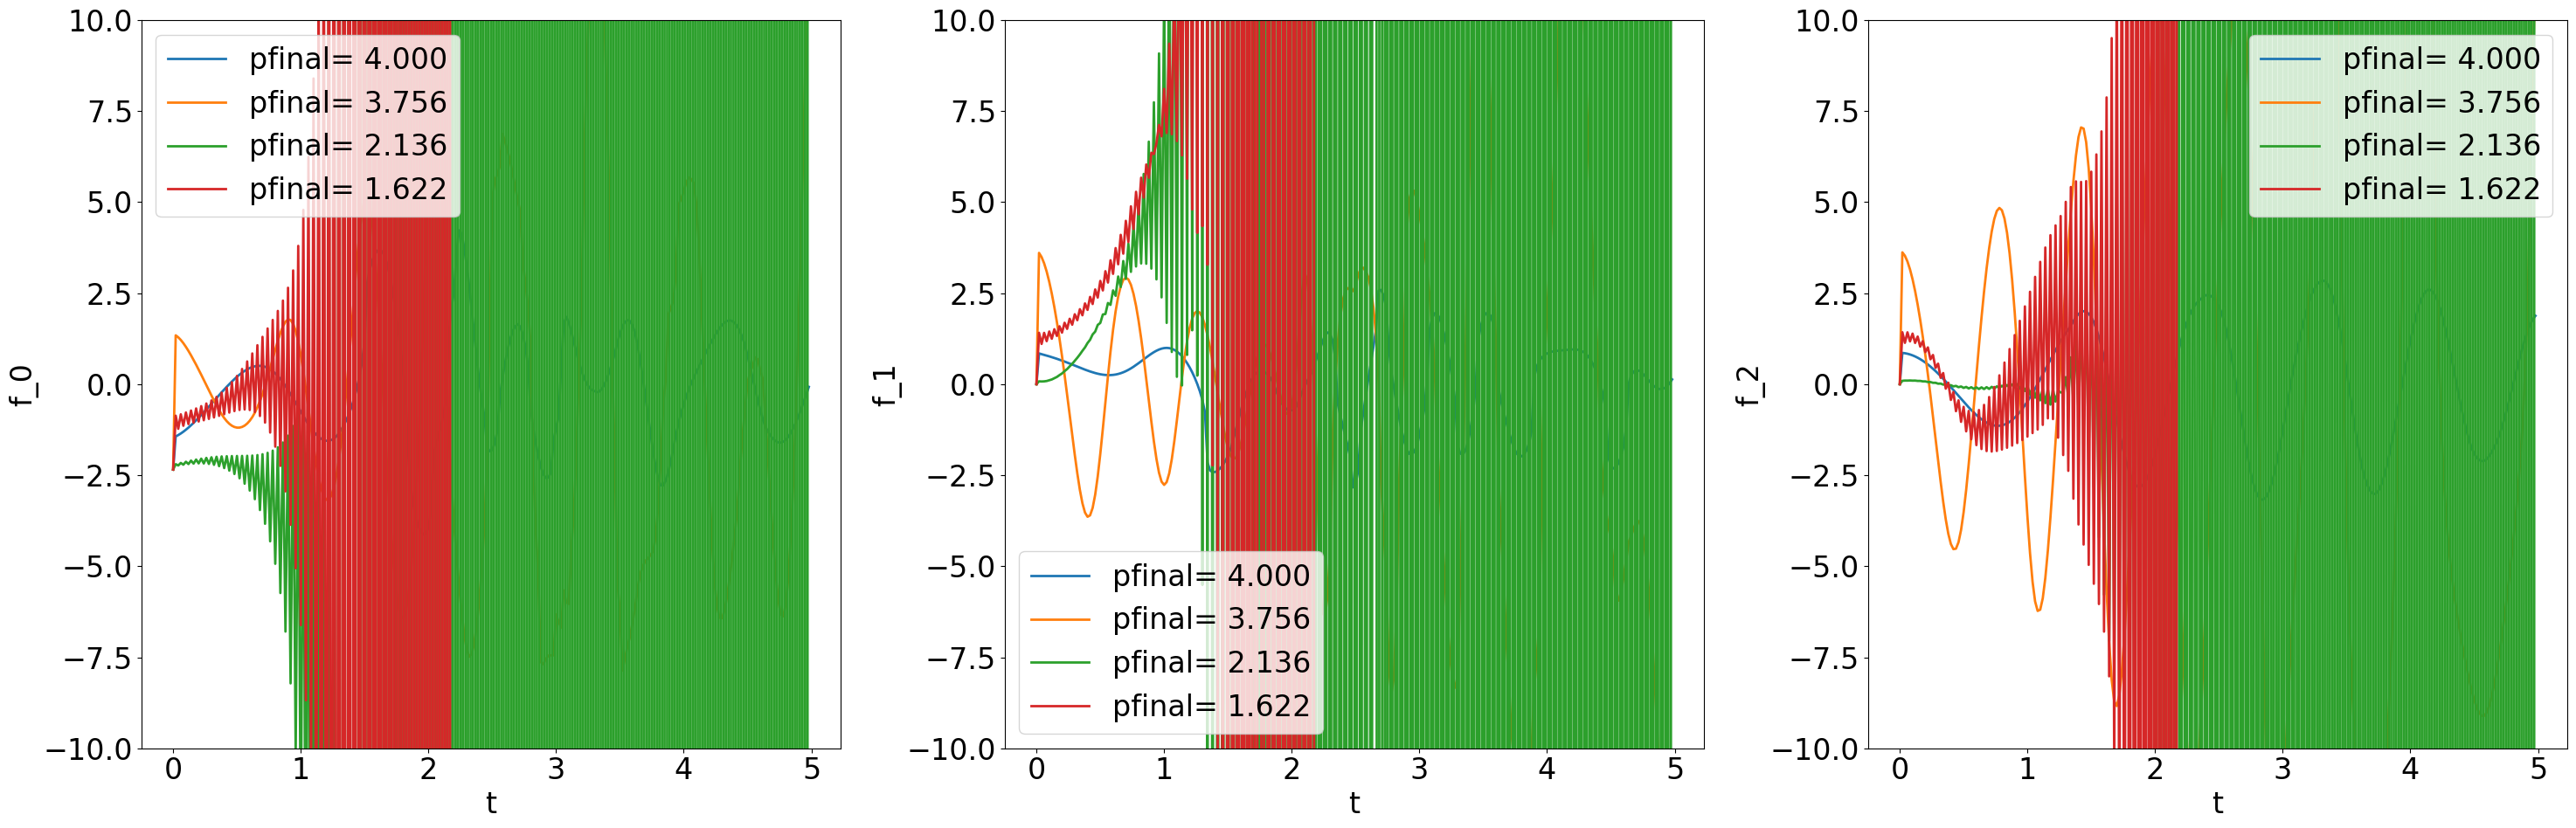

In [119]:
params = {
    'seed': '0',
    'M': '50',
    'pfreq': '50',
    'regP': '10.00',
}
compare_models(params, 'test_results/pnorm_varfreq', 'pinit')

## Case 2: `M=25`, `p_freq=50`, `reg_P=10`

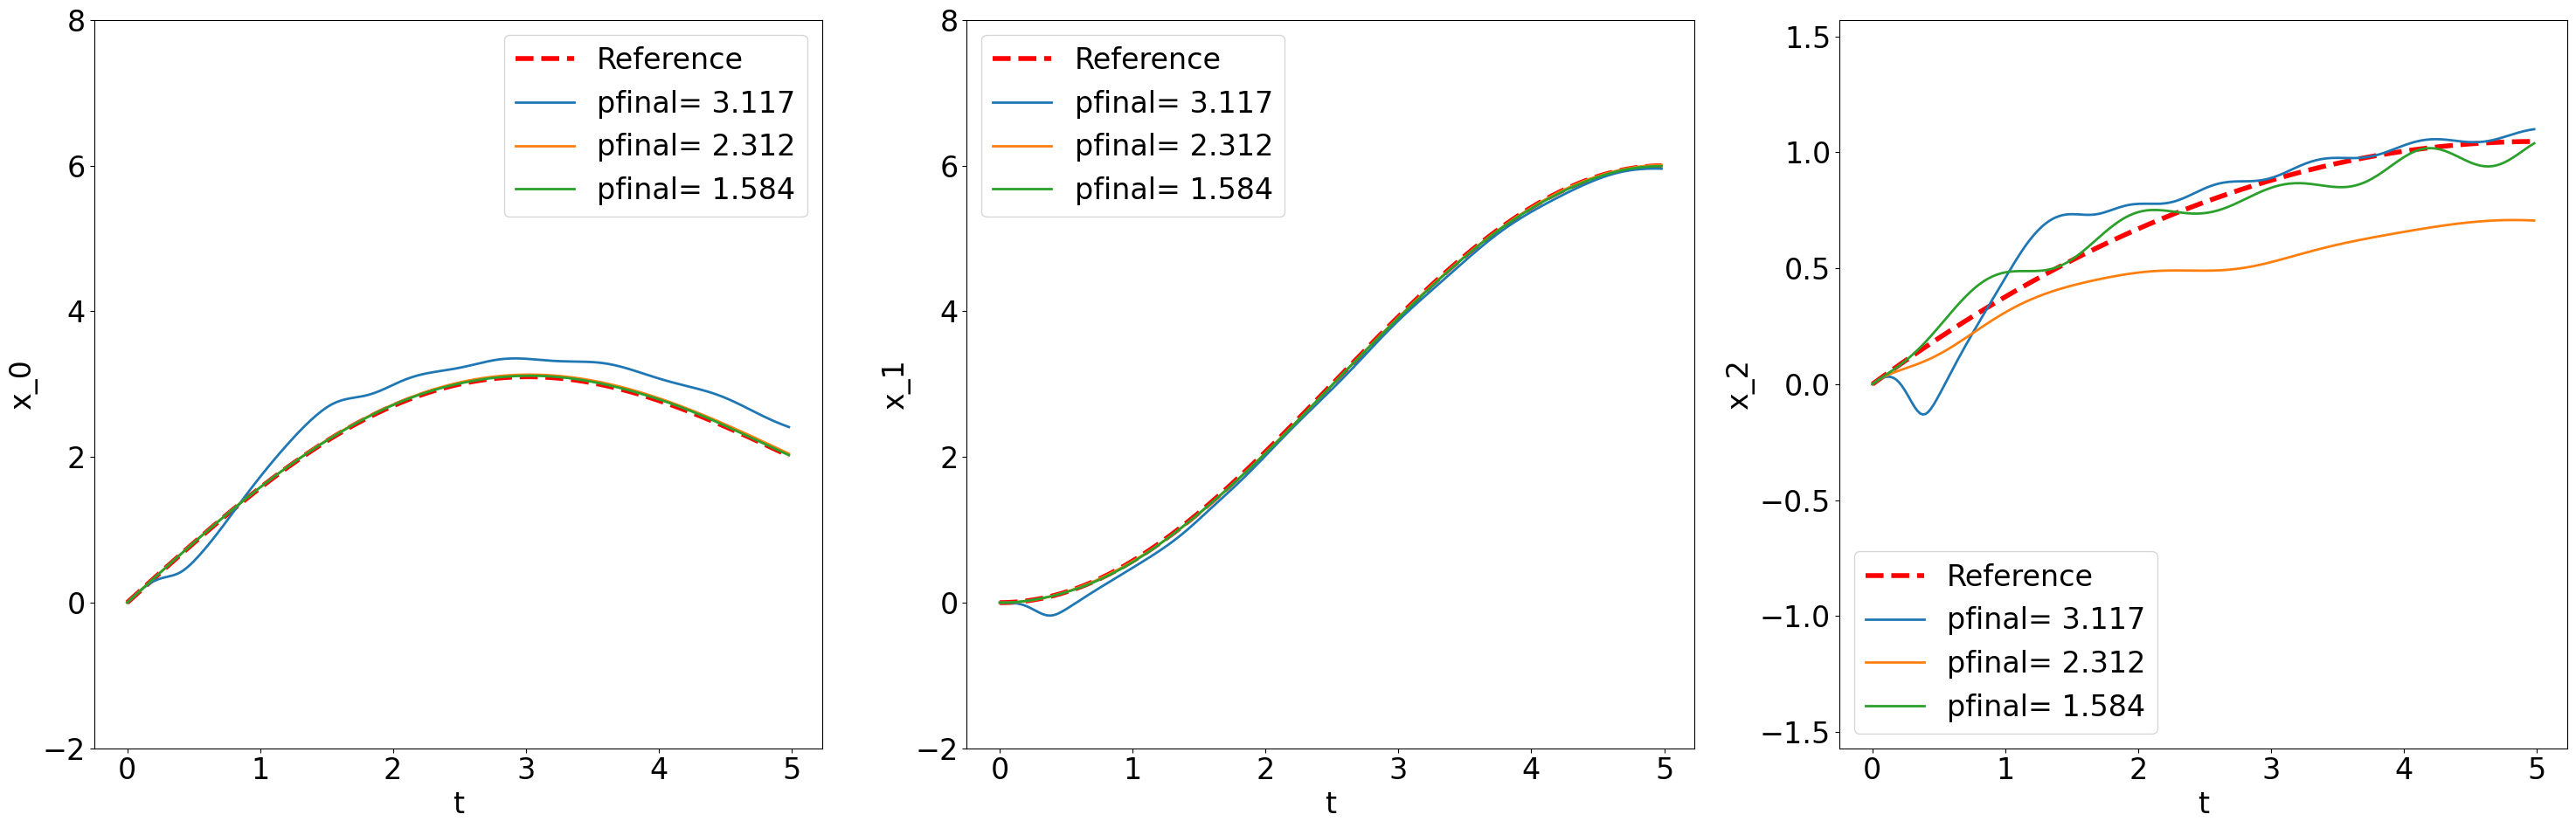

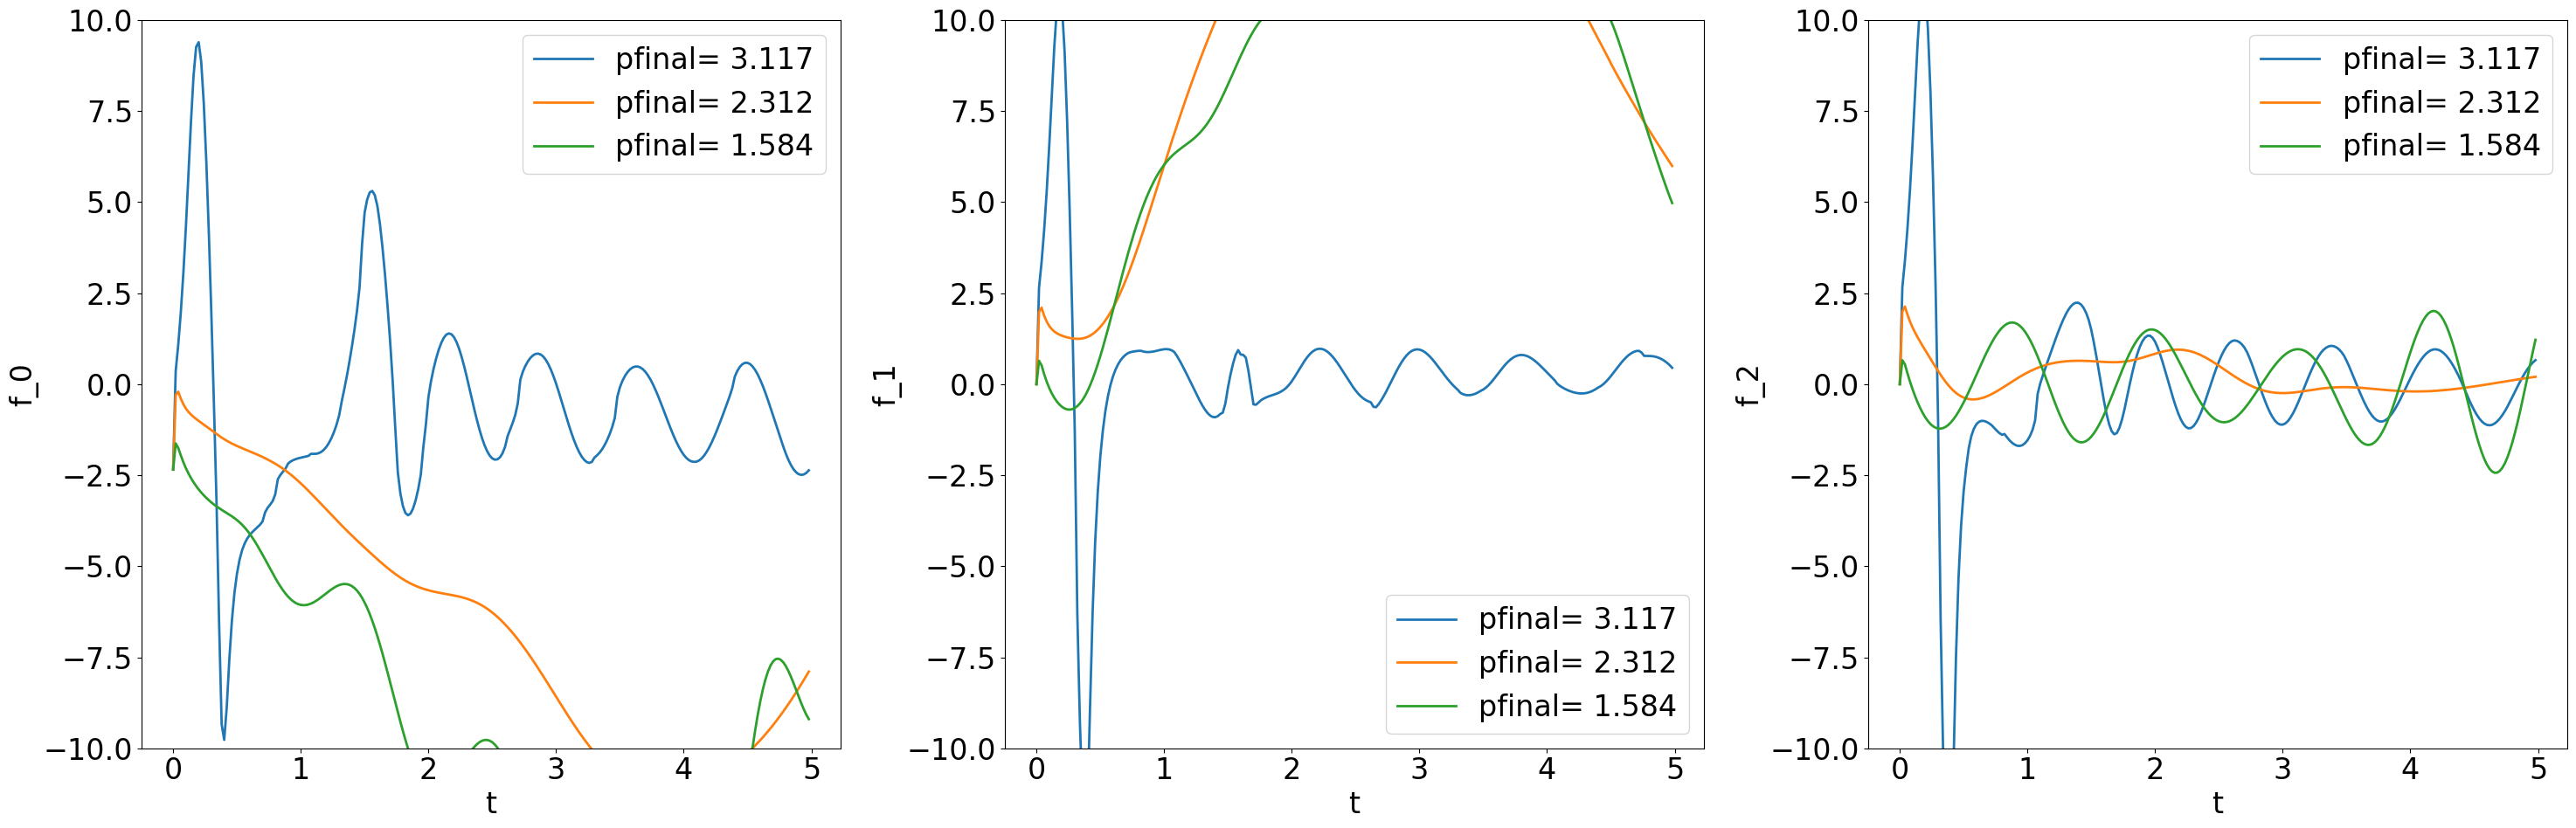

In [120]:
params = {
    'seed': '0',
    'M': '25',
    'pfreq': '50',
    'regP': '10.00',
}
compare_models(params, 'test_results/pnorm_varfreq', 'pinit')

## Case 3: `M=25`, `p_freq=50`, `reg_P=5.0`

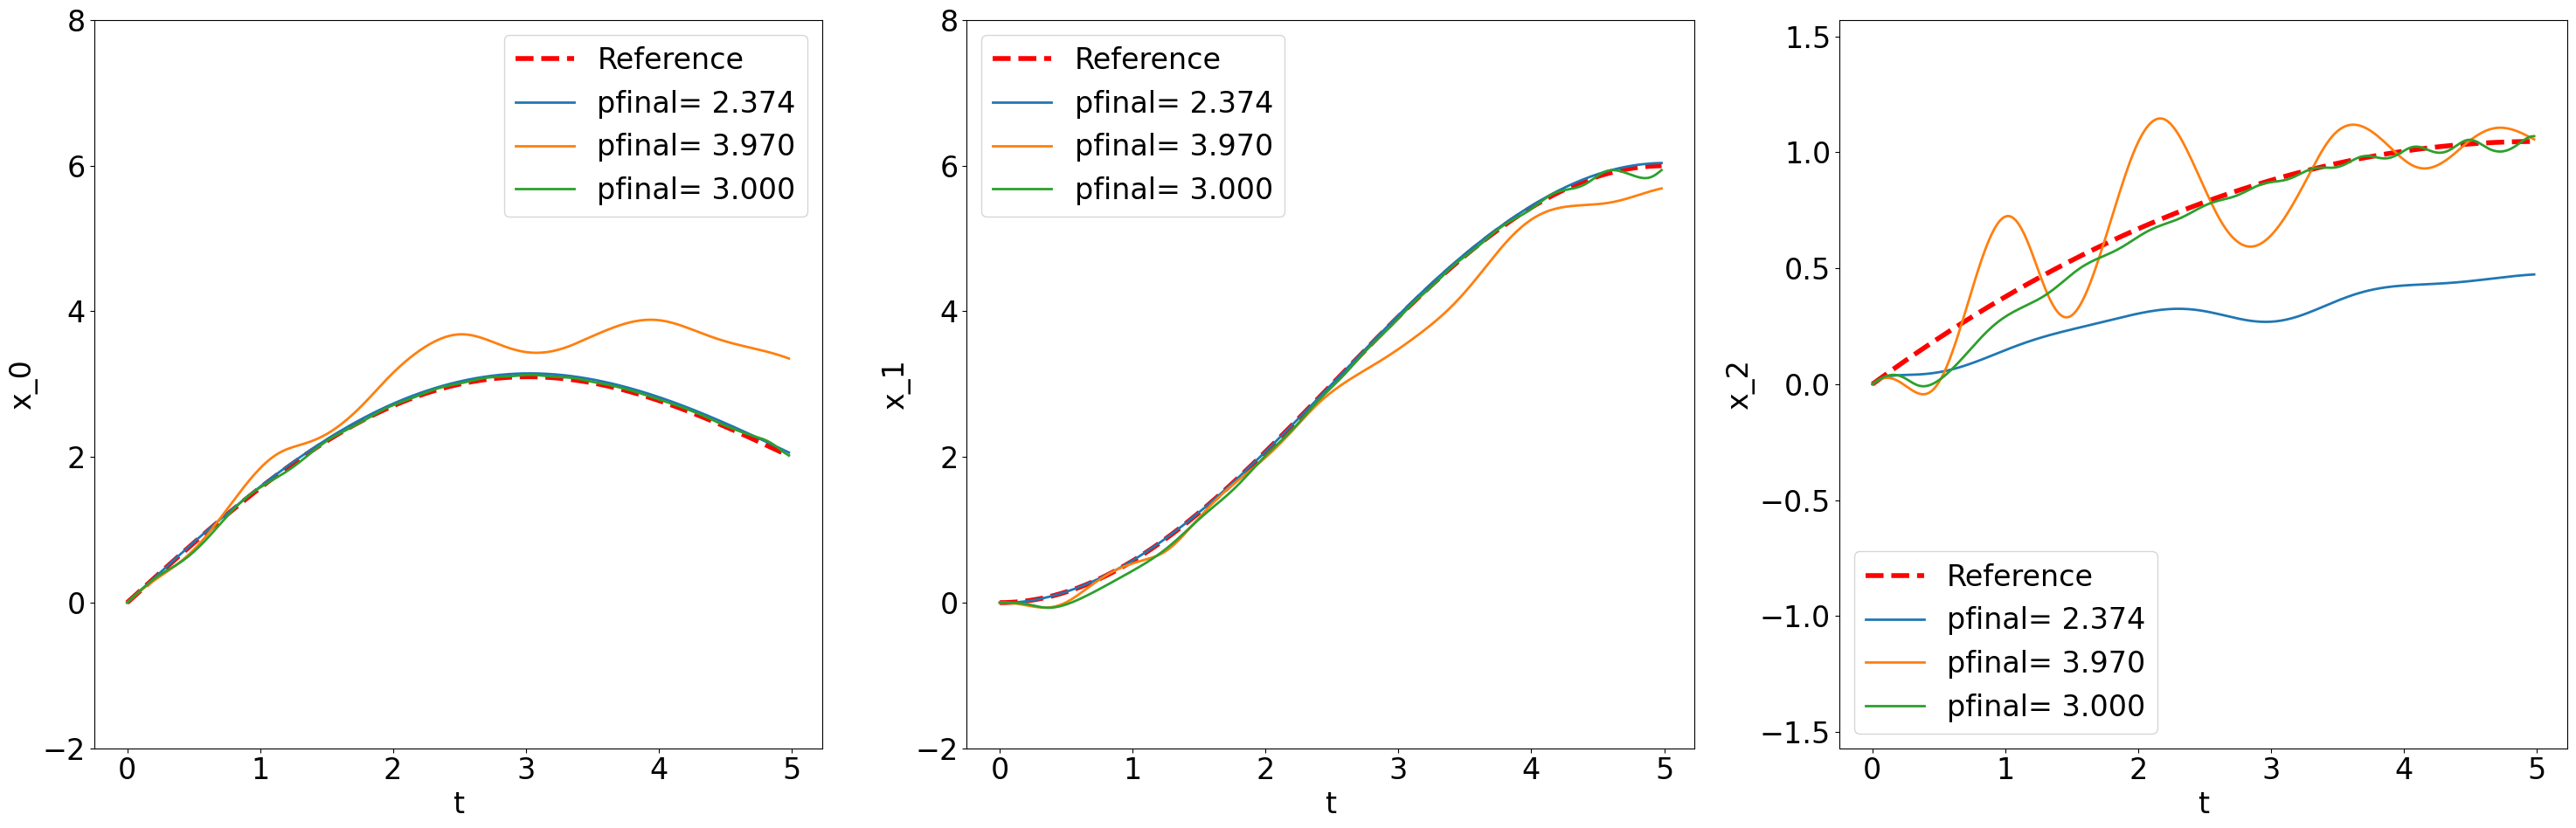

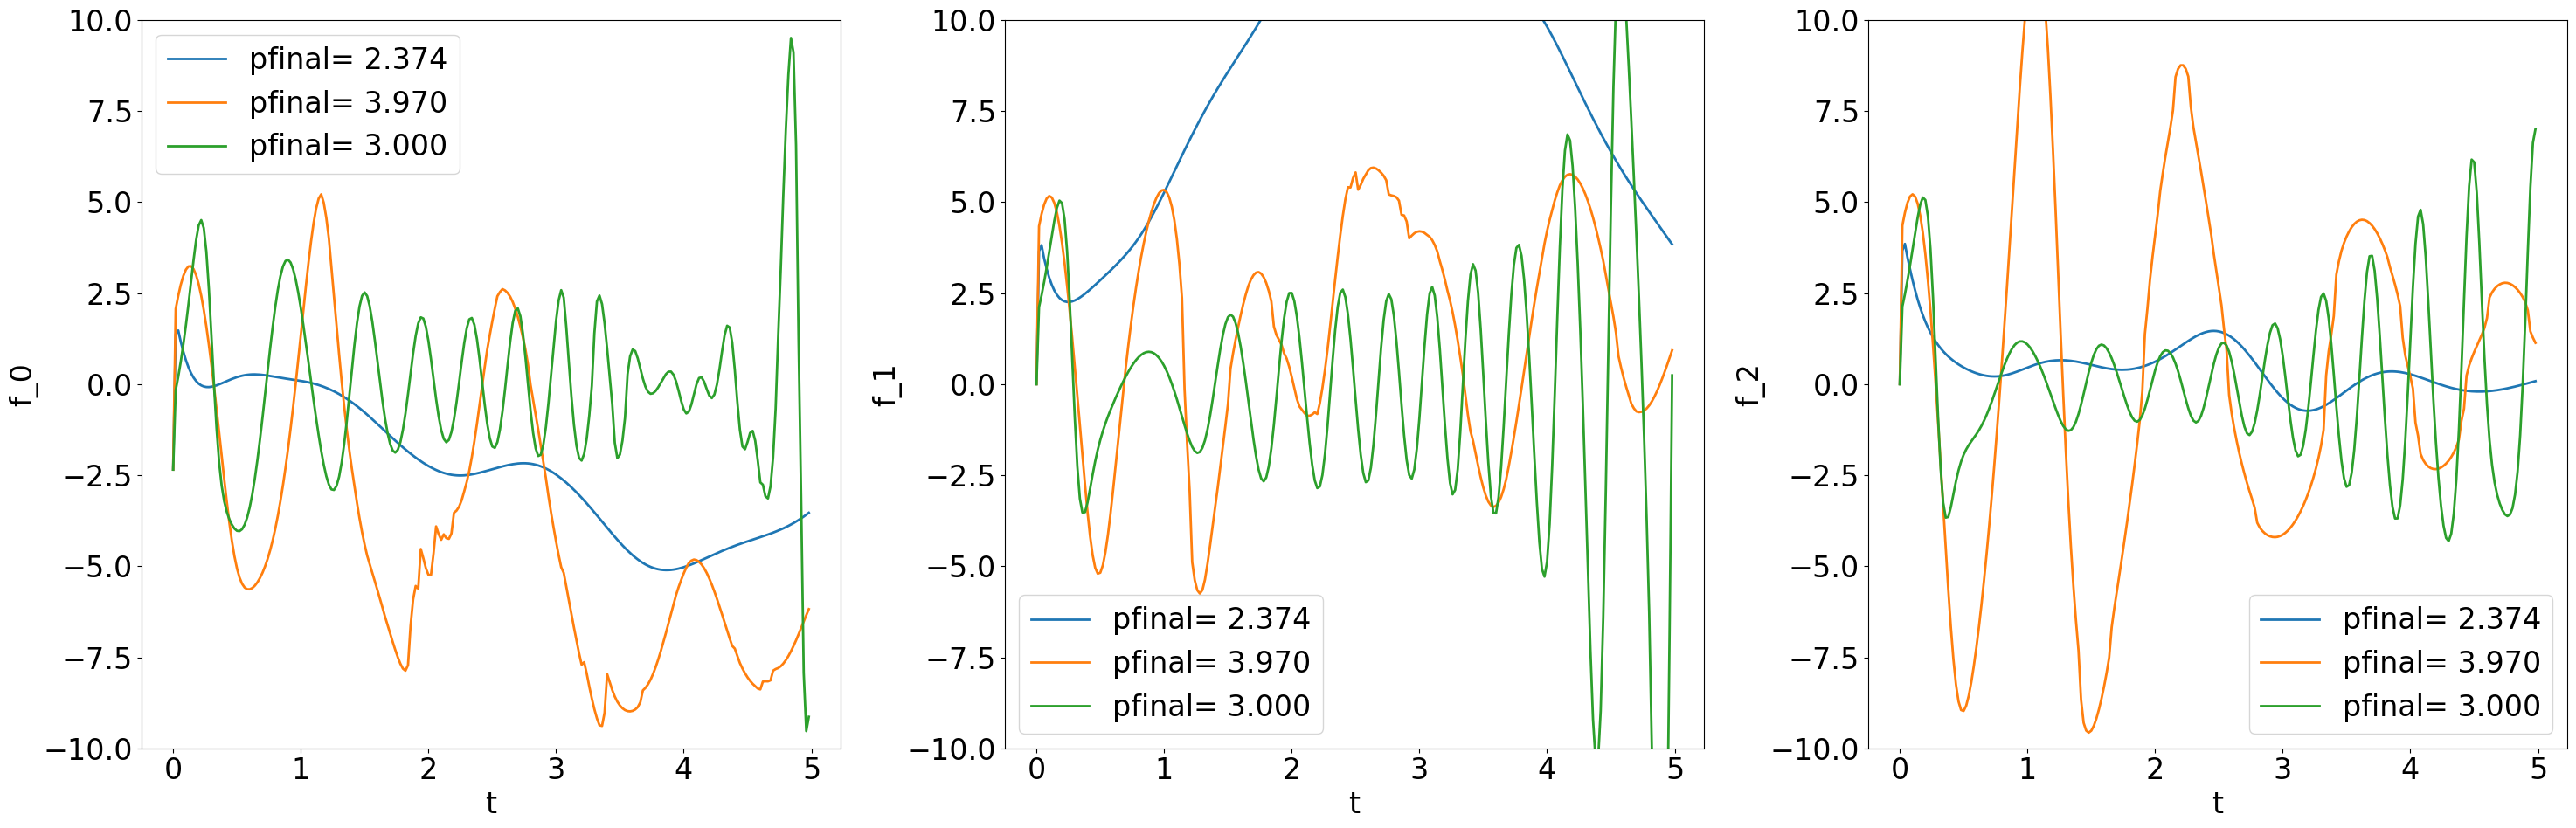

In [121]:
params = {
    'seed': '0',
    'M': '25',
    'pfreq': '50',
    'regP': '5.00',
}
compare_models(params, 'test_results/pnorm_varfreq', 'pinit')

## Case 4: `M=25`, `p_freq=500`, `reg_P=5.0`

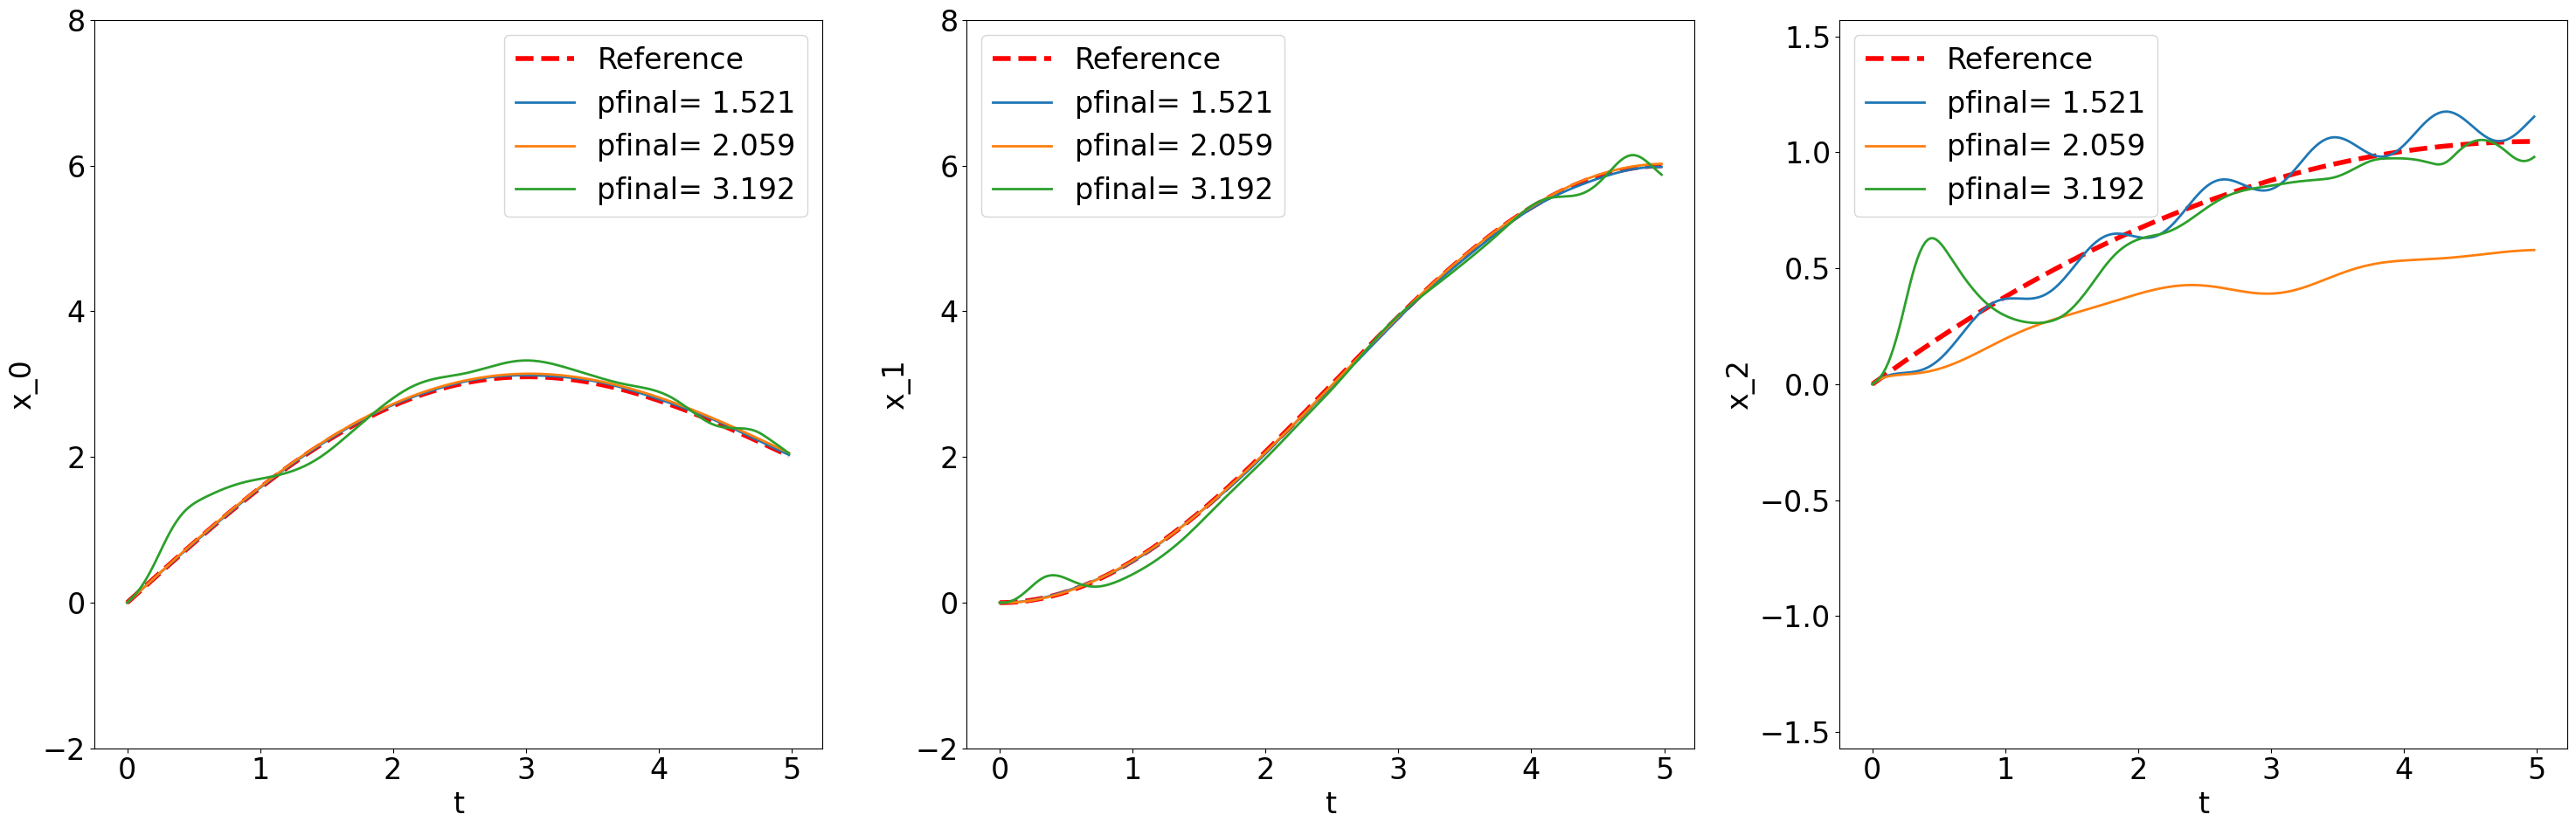

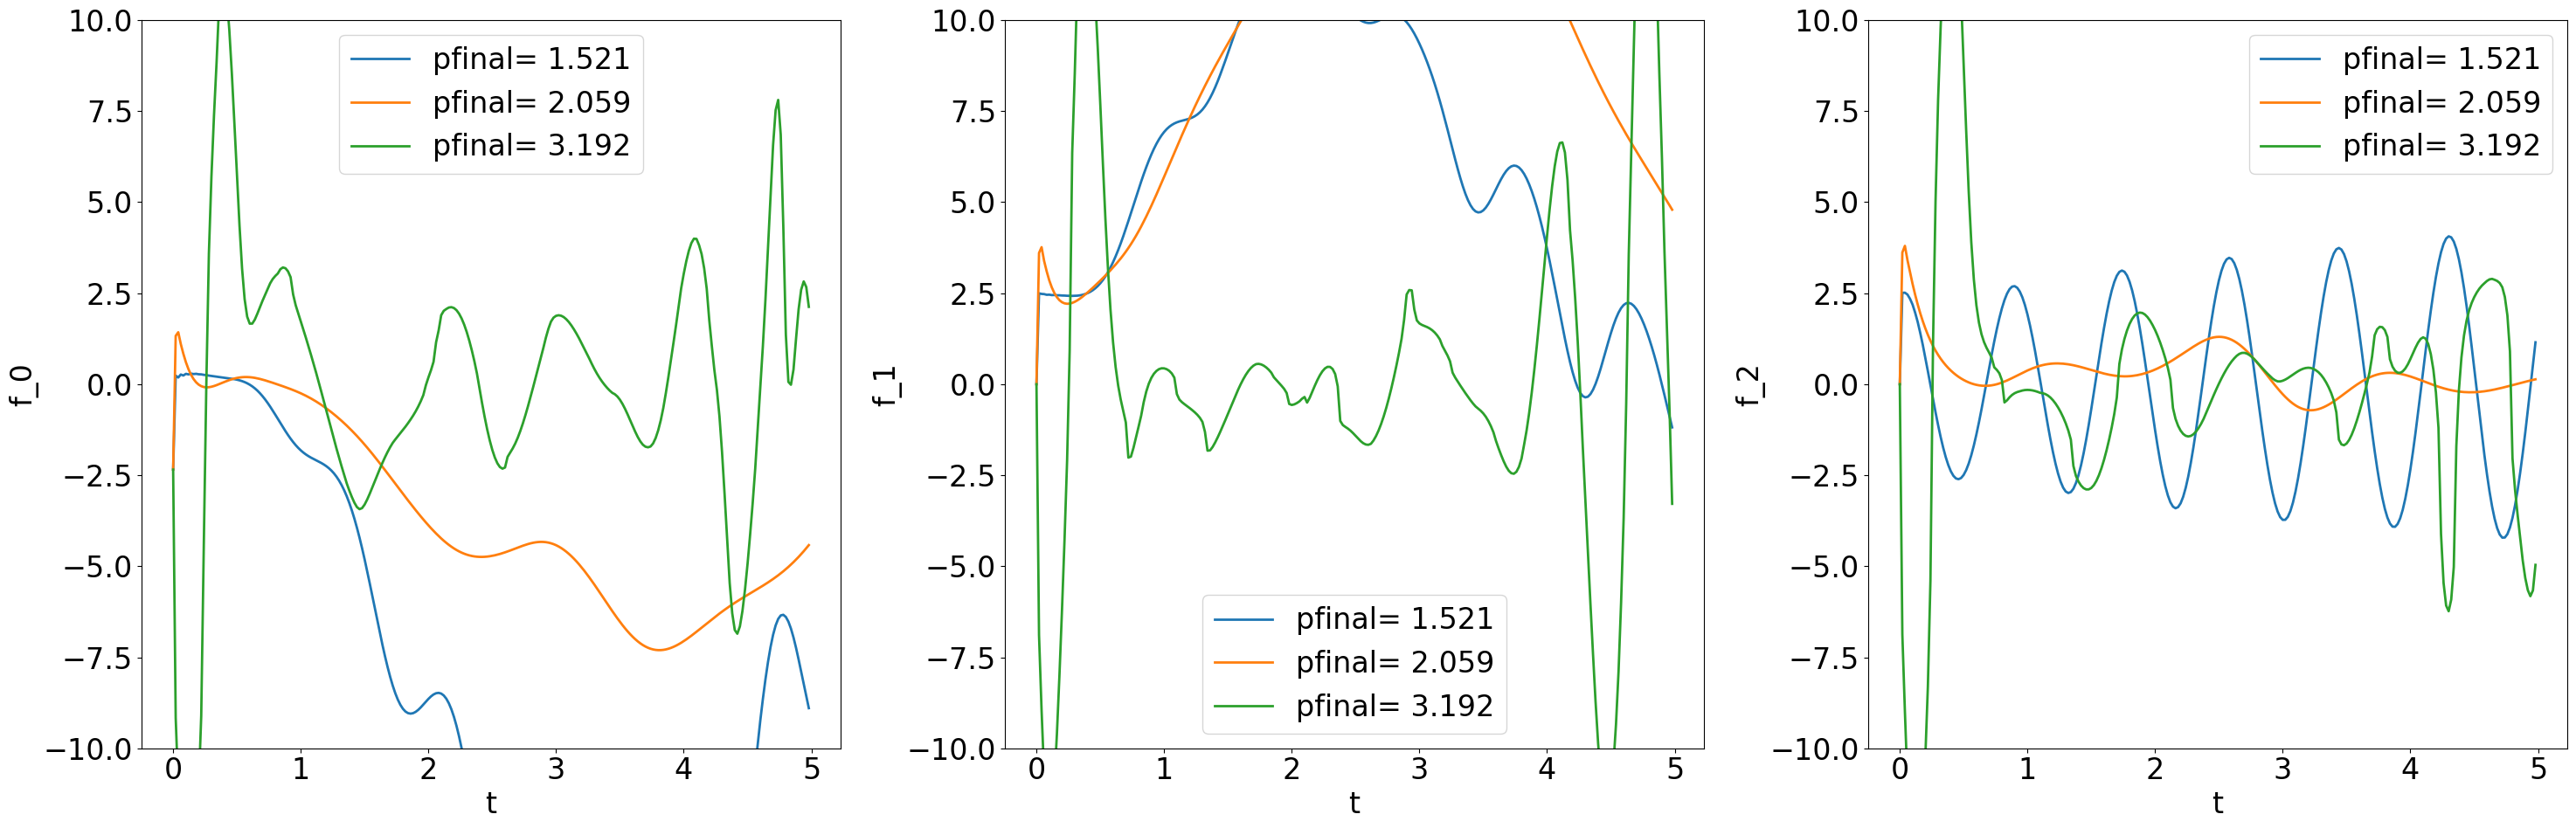

In [123]:
params = {
    'seed': '0',
    'M': '25',
    'pfreq': '500',
    'regP': '5.00',
}
compare_models(params, 'test_results/pnorm_varfreq', 'pinit')

## Case 5: `M=25`, `p_freq=500`, `reg_P=10.0`

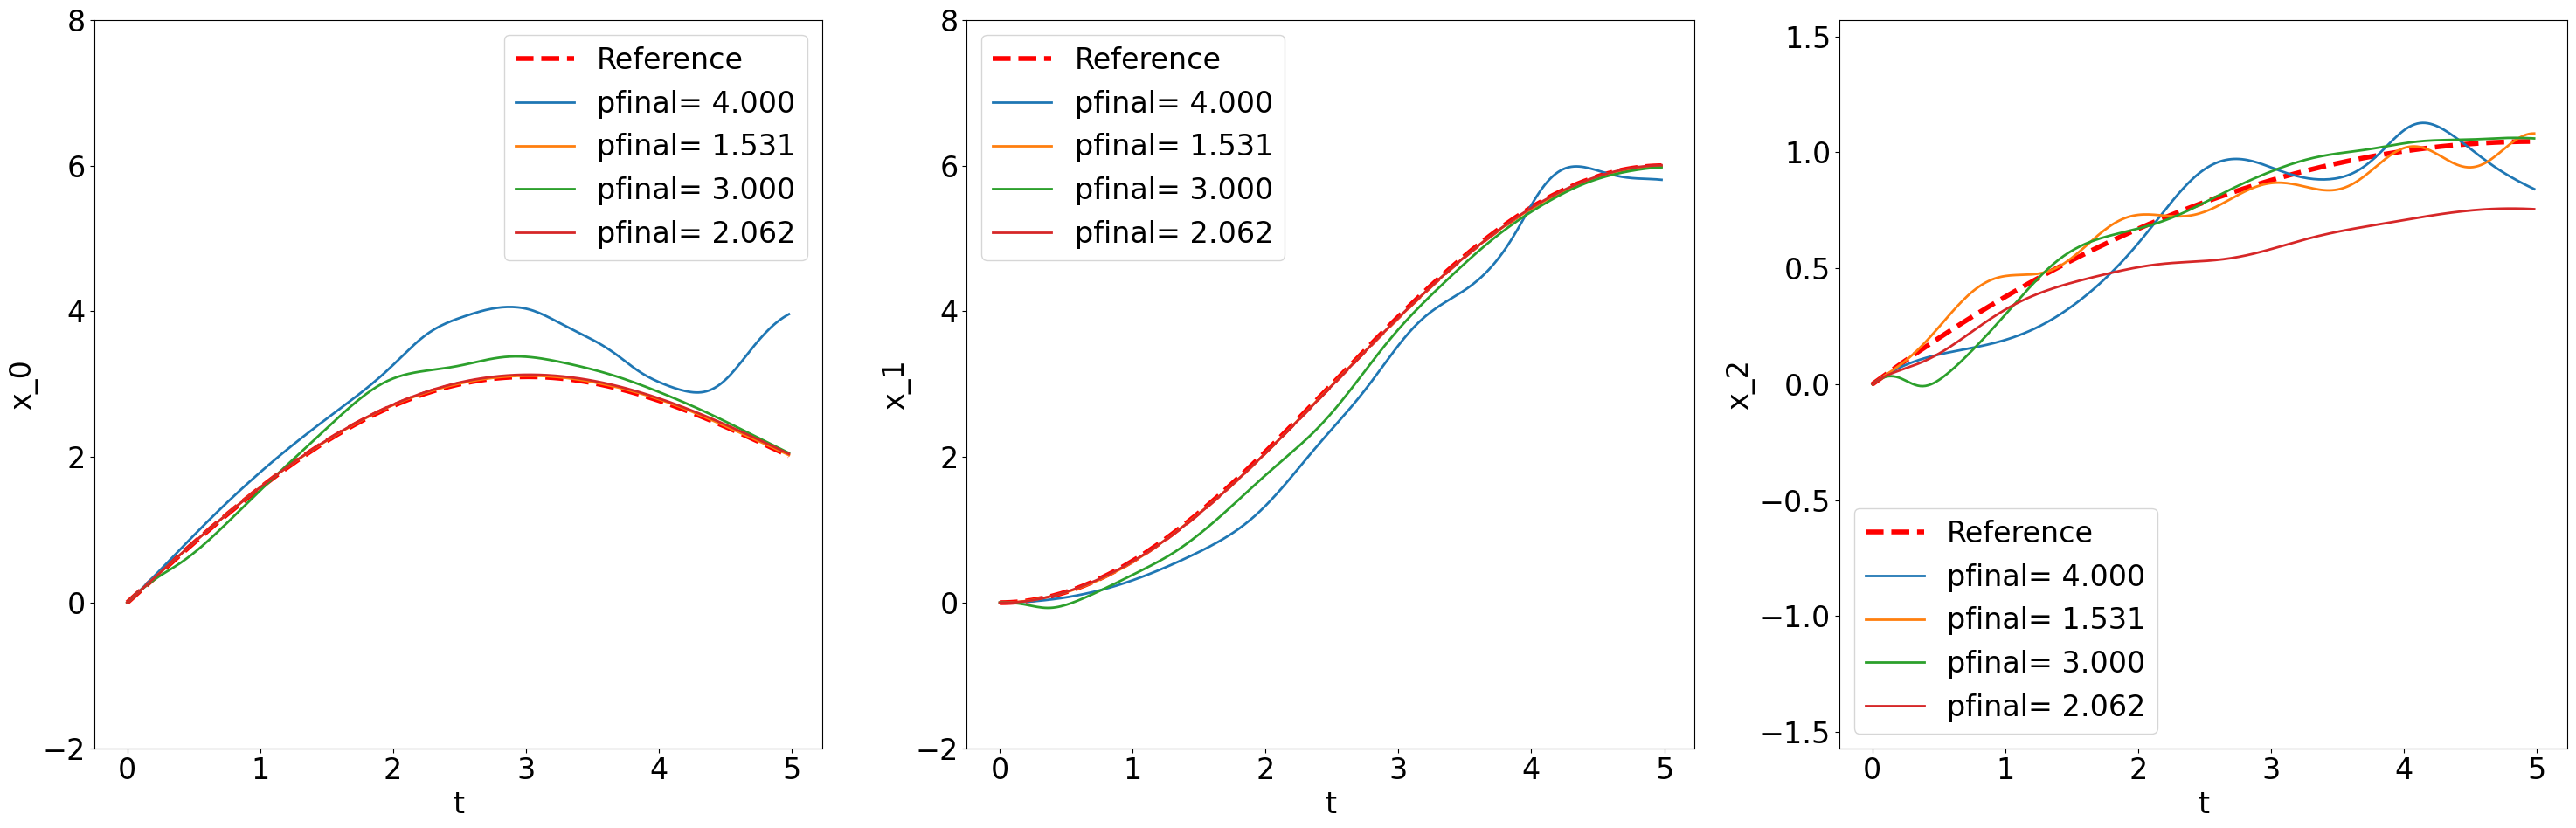

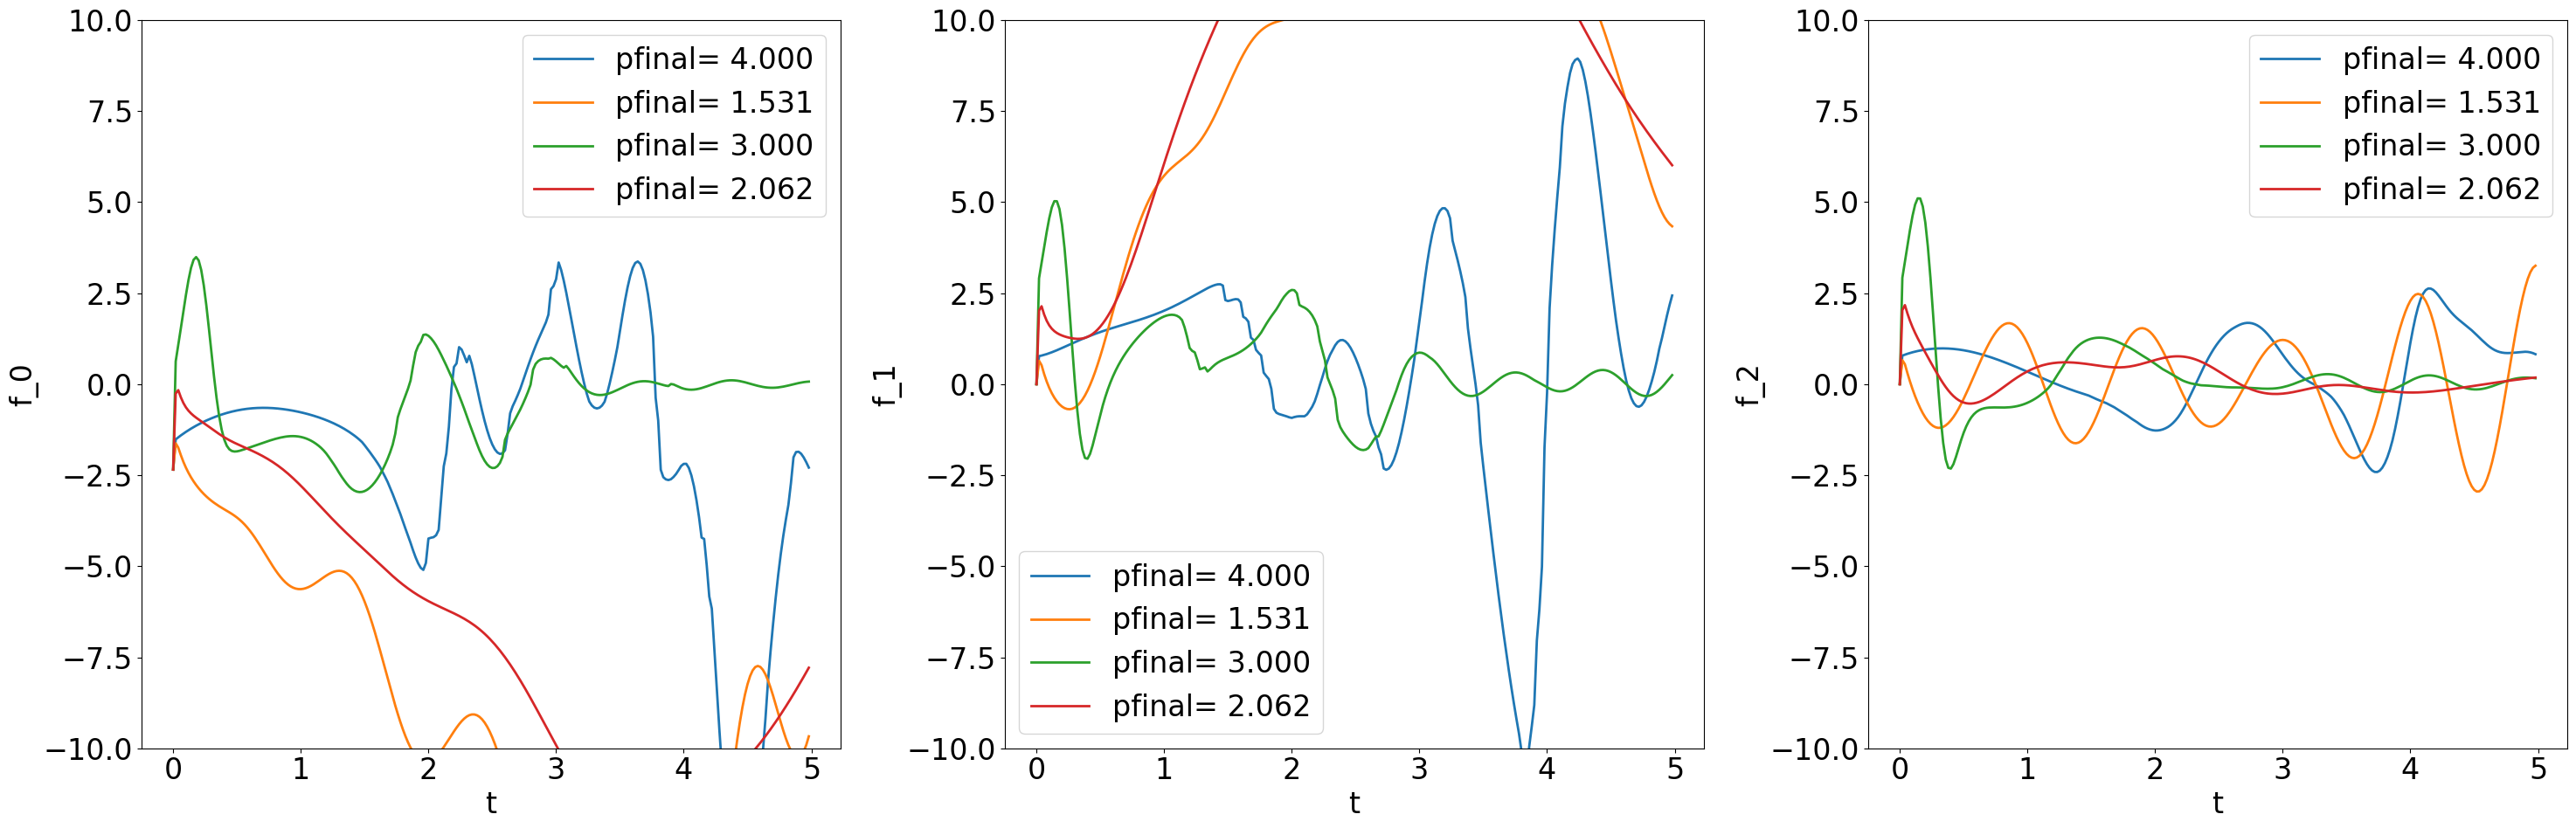

In [124]:
params = {
    'seed': '0',
    'M': '25',
    'pfreq': '500',
    'regP': '10.00',
}
compare_models(params, 'test_results/pnorm_varfreq', 'pinit')

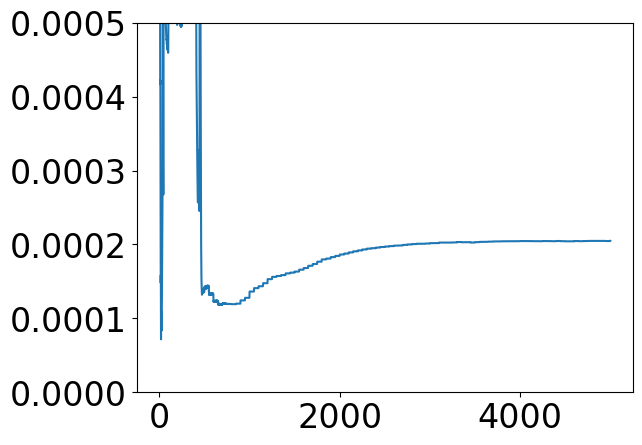

In [136]:
with open(os.path.join('test_results/pnorm_varfreq', 'test_seed=0_M=50_E=5000_pinit=4.00_pfreq=50_regP=10.00.pkl'), 'rb') as f:
    test_dict = pickle.load(f)
    fig, ax = plt.subplots(1, 1)
    ax.plot(range(int(test_dict['results']['train_params']['E'])), test_dict['results']['train_info']['valid_loss_history'])
    ax.set_ylim([0, 0.0005])